(tut_two)=

# **Partial Network Quantization**

This example shows how the NVIDIA TensorFlow 2.x Quantization Toolkit can be used to quantize only a few layers in a
TensorFlow 2.x model.

```{eval-rst}

.. admonition:: Goal
    :class: note

    #. Take a resnet-like model and train on cifar10 dataset.
    #. Quantize only layers named 'conv2d_2' and 'dense' in the model.
    #. Fine-tune to recover model accuracy.
    #. Save both original and quantized model while performing ONNX conversion.

```

```{eval-rst}

.. admonition:: Background
    :class: tip

    Few/specific layers to quantize are passed to ``quantize_model`` function as an object of ``QuantizationSpec`` class. 
    quantization mode is set to ``partial`` in ``quantize_model`` function. 

    Adding layers with single input to ``QuantizationSpec`` is rather simple. However, for multi-input layers, flexibility to quantize specific inputs is also provided.  
    
    For example, user wants to quantize layers with name ``conv2d_2`` and ``add``. 

    Default behavior of ``Add`` layer class is NOT to quantize any input. None of inputs to the ``Add`` class layer is quantized when following code snippet is used. 
    
    .. code-block:: python

        q_spec = QuantizationSpec()
        layer_name = ['conv2d_2']
        q_spec.add(name=layer_name, quantization_index=layer_quantization_index)

        q_model = quantize_model(model, quantization_spec=q_spec)

    
    However, when layer of ``Add`` class is passed via ``QuantizationSpec`` object, all inputs are quantized.  

    .. code-block:: python

        q_spec = QuantizationSpec()
        layer_name = ['conv2d_2', 'add']
        q_spec.add(name=layer_name, quantization_index=layer_quantization_index)

        q_model = quantize_model(model, quantization_spec=q_spec)

    
    Code to quantize input at specific index (in this case, 1) for layer ``add`` could look as follows.

    .. code-block:: python

        q_spec = QuantizationSpec()
        layer_name = ['conv2d_2', 'add']
        layer_quantization_index = [None, [1]]
        q_spec.add(name=layer_name, quantization_index=layer_quantization_index)

        q_model = quantize_model(model, quantization_spec=q_spec)

    Layer name can be found from the putput of ``model.summary()`` function for Functional and Sequetial models.
    For subclassed model, use ``KerasModelTravller`` class from tensorflow_quantization.utils.

```
Refer [Python API](qmodel_api) documentation for more details.

---


In [1]:

#
# SPDX-FileCopyrightText: Copyright (c) 1993-2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import tensorflow as tf
from tensorflow_quantization import quantize_model, QuantizationSpec
from tensorflow_quantization.custom_qdq_cases import ResNetV1QDQCase
import tiny_resnet
import os
from tensorflow_quantization import utils

tf.keras.backend.clear_session()

# Create folders to save TF and ONNX models
assets = utils.CreateAssetsFolders(os.path.join(os.getcwd(), "tutorials"))
assets.add_folder("simple_network_quantize_partial")

In [2]:
# Load CIFAR10 dataset
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

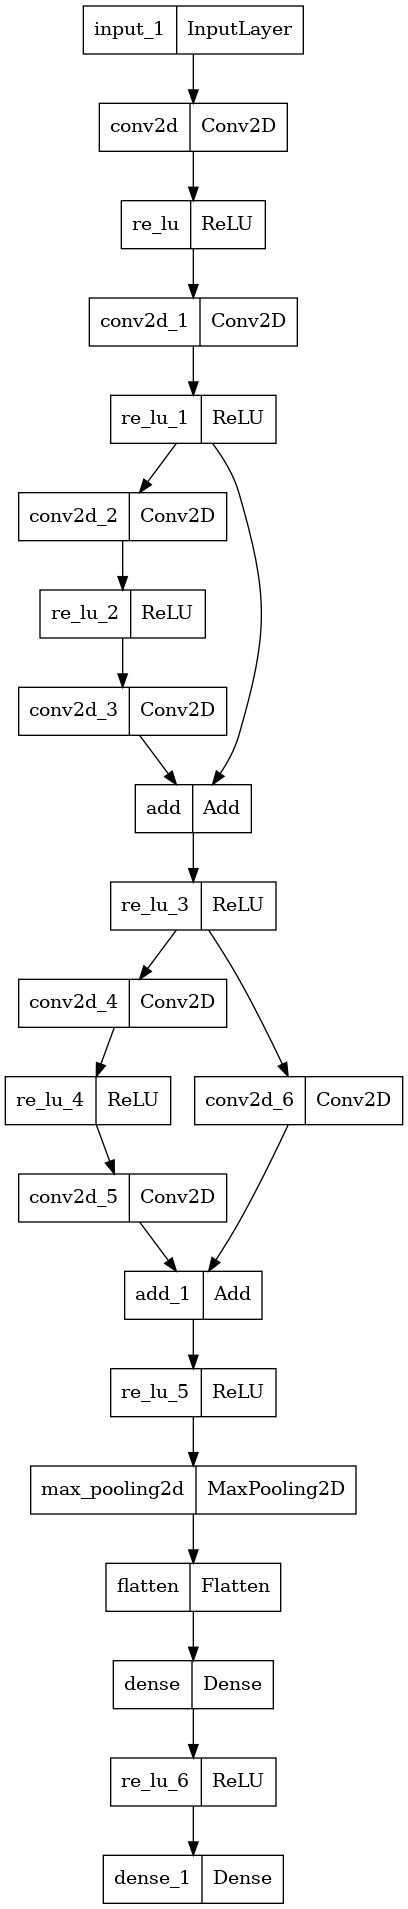

In [3]:
nn_model_original = tiny_resnet.model()
tf.keras.utils.plot_model(nn_model_original, to_file = assets.simple_network_quantize_partial.fp32 + "/model.png")

In [4]:
# Train original classification model
nn_model_original.compile(
    optimizer=tiny_resnet.optimizer(lr=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

nn_model_original.fit(
    train_images, train_labels, batch_size=32, epochs=10, validation_split=0.1
)

# Get baseline model accuracy
_, baseline_model_accuracy = nn_model_original.evaluate(
    test_images, test_labels, verbose=0
)
baseline_model_accuracy = round(100 * baseline_model_accuracy, 2)
print("Baseline FP32 model test accuracy:", baseline_model_accuracy)

Epoch 1/10
1407/1407 [==============================] - 18s 10ms/step - loss: 1.7617 - accuracy: 0.3615 - val_loss: 1.5624 - val_accuracy: 0.4300
Epoch 2/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4876 - accuracy: 0.4645 - val_loss: 1.4242 - val_accuracy: 0.4762
Epoch 3/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3737 - accuracy: 0.5092 - val_loss: 1.3406 - val_accuracy: 0.5202
Epoch 4/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2952 - accuracy: 0.5396 - val_loss: 1.2768 - val_accuracy: 0.5398
Epoch 5/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2370 - accuracy: 0.5649 - val_loss: 1.2466 - val_accuracy: 0.5560
Epoch 6/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1857 - accuracy: 0.5812 - val_loss: 1.2052 - val_accuracy: 0.5718
Epoch 7/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1442 - accuracy: 0.5972 - val_loss: 1.1836 -

In [5]:
# save TF FP32 original model
tf.keras.models.save_model(nn_model_original, assets.simple_network_quantize_partial.fp32_saved_model)

# Convert FP32 model to ONNX
utils.convert_saved_model_to_onnx(saved_model_dir = assets.simple_network_quantize_partial.fp32_saved_model, onnx_model_path = assets.simple_network_quantize_partial.fp32_onnx_model)

INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorials/simple_network_quantize_partial/fp32/saved_model/assets
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
ONNX conversion Done!


In [6]:
# Quantize model
# 1.1 Create a dictionary to quantize only two layers named 'conv2d_2' and 'dense'
qspec = QuantizationSpec()
layer_name = ['conv2d_2', 'dense']
qspec.add(name=layer_name)
# 1.2 Call quantize model function
q_nn_model = quantize_model(
    model=nn_model_original, quantization_mode="partial", quantization_spec=qspec)

q_nn_model.compile(
    optimizer=tiny_resnet.optimizer(lr=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

[I] Layer `conv2d` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `re_lu` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `conv2d_1` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `re_lu_1` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `re_lu_2` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `conv2d_3` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `re_lu_3` is not quantized. Partial quantization is enabled and layer name is not in user provided QuantizationSpec class object
[I] Layer `conv2d_4` is not 

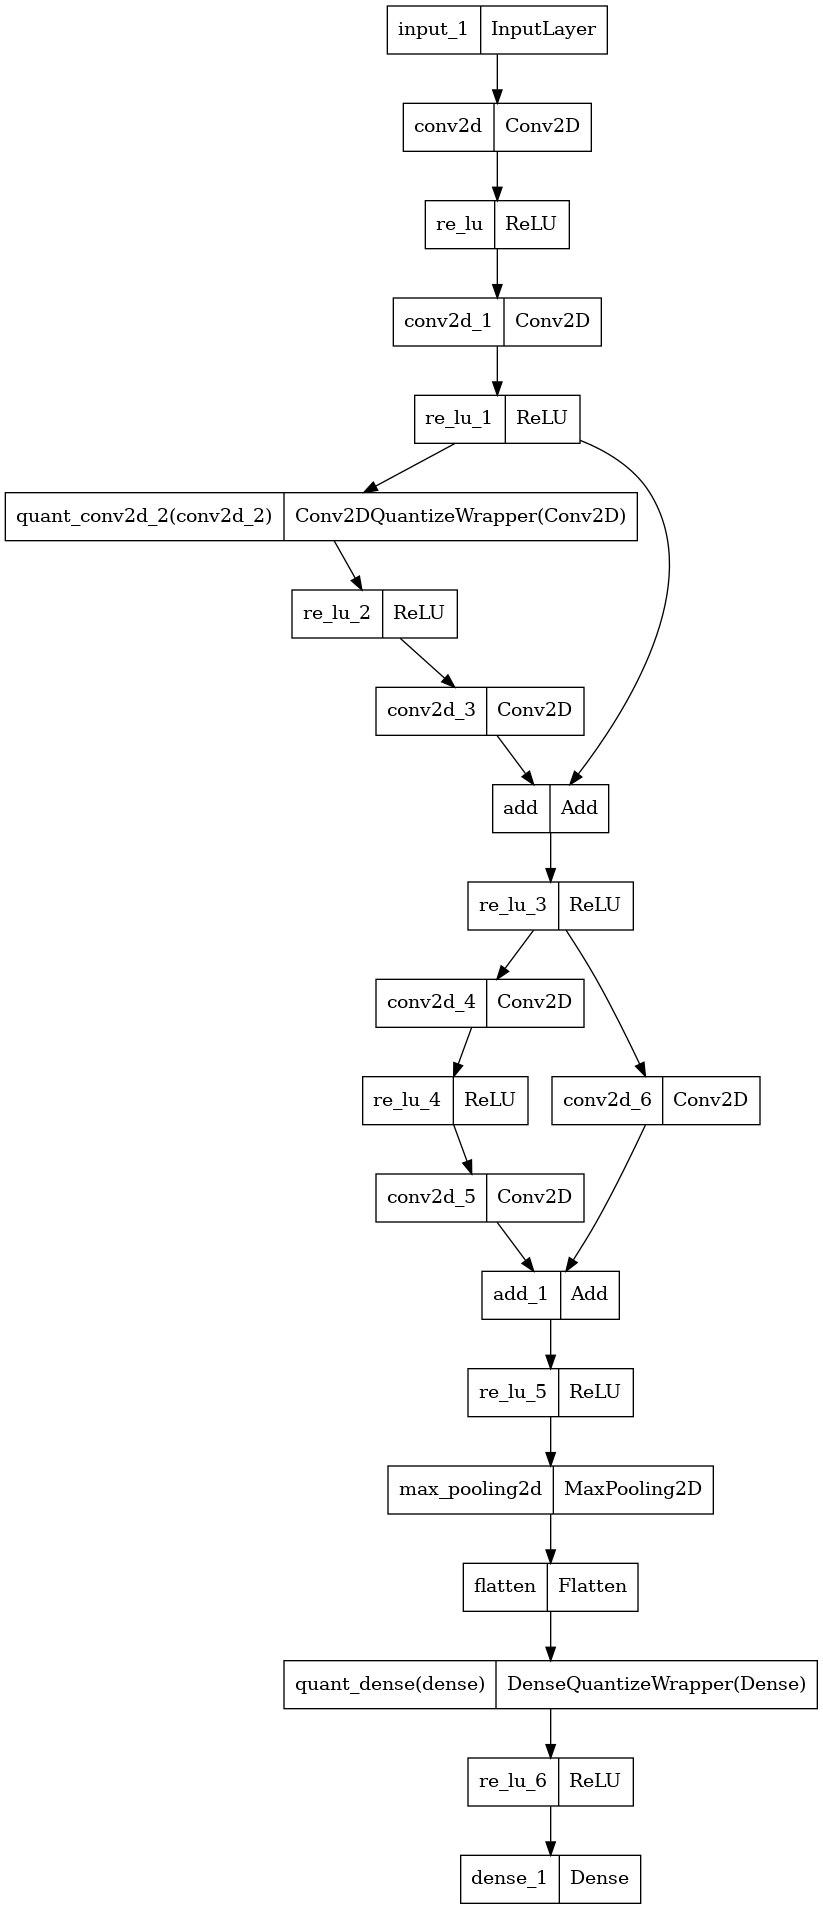

In [7]:
tf.keras.utils.plot_model(q_nn_model, to_file = assets.simple_network_quantize_partial.int8 + "/model.png")

In [8]:
_, q_model_accuracy = q_nn_model.evaluate(test_images, test_labels, verbose=0)
q_model_accuracy = round(100 * q_model_accuracy, 2)
print(
    "Test accuracy immediately after quantization:{}, diff:{}".format(
        q_model_accuracy, (baseline_model_accuracy - q_model_accuracy)
    )
)

Test accuracy immediately after quantization:58.96, diff:2.5


In [9]:
# Fine-tune quantized model
fine_tune_epochs = 2
q_nn_model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=fine_tune_epochs,
    validation_split=0.1,
)
_, q_model_accuracy = q_nn_model.evaluate(test_images, test_labels, verbose=0)
q_model_accuracy = round(100 * q_model_accuracy, 2)
print(
    "Accuracy after fine tuning for {} epochs :{}".format(
        fine_tune_epochs, q_model_accuracy
    )
)

Epoch 1/2
1407/1407 [==============================] - 20s 14ms/step - loss: 1.0074 - accuracy: 0.6480 - val_loss: 1.0854 - val_accuracy: 0.6194
Epoch 2/2
1407/1407 [==============================] - 19s 14ms/step - loss: 0.9799 - accuracy: 0.6583 - val_loss: 1.0782 - val_accuracy: 0.6242
Accuracy after fine tuning for 2 epochs :62.0


In [10]:
# Save TF INT8 original model
tf.keras.models.save_model(q_nn_model, assets.simple_network_quantize_partial.int8_saved_model)

# Convert INT8 model to ONNX
utils.convert_saved_model_to_onnx(saved_model_dir = assets.simple_network_quantize_partial.int8_saved_model, onnx_model_path = assets.simple_network_quantize_partial.int8_onnx_model)

tf.keras.backend.clear_session()

INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorials/simple_network_quantize_partial/int8/saved_model/assets


INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorials/simple_network_quantize_partial/int8/saved_model/assets


ONNX conversion Done!


```{note}
ONNX files can be visualized with [Netron](https://netron.app/).
```